In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers

from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

tf.keras.backend.set_floatx('float32')

In [3]:
# Load the dataset
train_df = pd.read_csv("california_housing_train.csv")
test_df = pd.read_csv("california_housing_test.csv")

In [17]:
train_df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
3429,-117.9,33.9,14.0,1562.0,373.0,609.0,328.0,2.4,125.0
6284,-118.2,34.0,30.0,962.0,291.0,1280.0,263.0,1.4,110.2
4726,-118.1,33.9,21.0,3933.0,949.0,2219.0,820.0,2.5,171.4
14561,-122.2,38.0,52.0,1888.0,457.0,830.0,408.0,3.1,185.1
10872,-120.8,37.8,16.0,893.0,164.0,548.0,155.0,3.7,121.9
...,...,...,...,...,...,...,...,...,...
16965,-124.2,40.8,46.0,1975.0,346.0,791.0,349.0,3.8,81.8
690,-117.0,33.1,22.0,2427.0,390.0,1099.0,362.0,5.2,167.5
15939,-122.4,37.8,52.0,2960.0,623.0,1191.0,589.0,4.0,347.7
4075,-118.0,34.1,27.0,6341.0,1289.0,2899.0,1192.0,3.6,235.2


In [18]:
test_df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.0,37.4,27.0,3885.0,661.0,1537.0,606.0,6.6,344.7
1,-118.3,34.3,43.0,1510.0,310.0,809.0,277.0,3.6,176.5
2,-117.8,33.8,27.0,3589.0,507.0,1484.0,495.0,5.8,270.5
3,-118.4,33.8,28.0,67.0,15.0,49.0,11.0,6.1,330.0
4,-119.7,36.3,19.0,1241.0,244.0,850.0,237.0,2.9,81.7
...,...,...,...,...,...,...,...,...,...
2995,-119.9,34.4,23.0,1450.0,642.0,1258.0,607.0,1.2,225.0
2996,-118.1,34.1,27.0,5257.0,1082.0,3496.0,1036.0,3.4,237.2
2997,-119.7,36.3,10.0,956.0,201.0,693.0,220.0,2.3,62.0
2998,-117.1,34.1,40.0,96.0,14.0,46.0,14.0,3.3,162.5


In [4]:
# Scale the labels
scale_factor = 1000.0
# Scale the training set's label.
train_df["median_house_value"] /= scale_factor 

# Scale the test set's label
test_df["median_house_value"] /= scale_factor

# Shuffle the examples
train_df = train_df.reindex(np.random.permutation(train_df.index))

In [5]:
# Create an empty list that will eventually hold all feature columns.
feature_columns = []

# Create a numerical feature column to represent latitude.
latitude = tf.feature_column.numeric_column("latitude")
feature_columns.append(latitude)

# Create a numerical feature column to represent longitude.
longitude = tf.feature_column.numeric_column("longitude")
feature_columns.append(longitude)

# Convert the list of feature columns into a layer that will ultimately become
# part of the model. Understanding layers is not important right now.
fp_feature_layer = layers.DenseFeatures(feature_columns)

In [7]:
#@title Define functions to create and train a model, and a plotting function
def create_model(my_learning_rate, feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(feature_layer)

  # Add one linear layer to the model to yield a simple linear regressor.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model   

In [8]:
def train_model(model, dataset, epochs, batch_size, label_name):
  """Feed a dataset into the model in order to train it."""

  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True)

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  
  # Isolate the mean absolute error for each epoch.
  hist = pd.DataFrame(history.history)
  rmse = hist["root_mean_squared_error"]

  return epochs, rmse  

In [9]:
def plot_the_loss_curve(epochs, rmse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.94, rmse.max()* 1.05])
  plt.show()  

print("Defined the create_model, train_model, and plot_the_loss_curve functions.")

Defined the create_model, train_model, and plot_the_loss_curve functions.


Epoch 1/35
Consider rewriting this model with the Functional API.


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Consider rewriting this model with the Functional API.
850/850 [==============================] - 2s 1ms/step - loss: 15226.8721 - root_mean_squared_error: 123.3972
Epoch 2/35
850/850 [==============================] - 1s 1ms/step - loss: 13470.4678 - root_mean_squared_error: 116.0623
Epoch 3/35
850/850 [==============================] - 1s 2ms/step - loss: 13438.2344 - root_mean_squared_error: 115.9234
Epoch 4/35
850/850 [==============================] - 1s 1ms/step - loss: 13419.0000 - root_mean_squared_error: 115.8404
Epoch 5/35
850/850 [==============================] - 1s 1ms/step - loss: 13394.3760 - root_mean_squared_error: 115.7341
Epoch 6/35
850/850 [==============================] - 1s 2ms/step - loss: 13363.7207 - root_mean_squared_error: 115.6016
Epoch 7/35
850/850 [==============================] - 1s 2ms/step - loss: 13345.2930 - root_mean_squared_error: 115.5218
Epoch 8/35
850/850 [==============================] - 1s 2ms/step - loss: 13324.6602 - root_mean_squared_erro

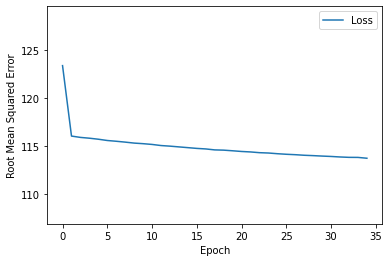


: Evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
150/150 [==============================] - 0s 2ms/step - loss: 12310.2012 - root_mean_squared_error: 110.9513


[12310.201171875, 110.95134735107422]

In [14]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 35
batch_size = 20
label_name = 'median_house_value'

# Create and compile the model's topography.
my_model = create_model(learning_rate, fp_feature_layer)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = np.array(test_features.pop(label_name))
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

In [15]:
# Calculate the Z-scores of each column in the training set and
# write those Z-scores into a new pandas DataFrame named train_df_norm.
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean)/train_df_std

# Examine some of the values of the normalized training set. Notice that most 
# Z-scores fall between -2 and +2.
train_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
3429,0.8,-0.8,-1.2,-0.5,-0.4,-0.7,-0.5,-0.8,-0.7
6284,0.7,-0.8,0.1,-0.8,-0.6,-0.1,-0.6,-1.3,-0.8
4726,0.7,-0.8,-0.6,0.6,1.0,0.7,0.8,-0.7,-0.3
14561,-1.3,1.1,1.9,-0.3,-0.2,-0.5,-0.2,-0.4,-0.2
10872,-0.6,1.0,-1.0,-0.8,-0.9,-0.8,-0.9,-0.1,-0.7


In [16]:
# Create an empty list that will eventually hold all created feature columns.
feature_columns = []

# Create a numerical feature column to represent median_income.
median_income = tf.feature_column.numeric_column("median_income")
feature_columns.append(median_income)

# Create a numerical feature column to represent total_rooms.
tr = tf.feature_column.numeric_column("total_rooms")
feature_columns.append(tr)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
feature_layer = layers.DenseFeatures(feature_columns)

# Print the first 3 and last 3 rows of the feature_layer's output when applied
# to train_df_norm:
feature_layer(dict(train_df_norm))

<tf.Tensor: shape=(17000, 2), dtype=float32, numpy=
array([[-0.7808993 , -0.49618837],
       [-1.2772422 , -0.7714244 ],
       [-0.7289644 ,  0.5914527 ],
       ...,
       [ 0.03480946,  0.14511159],
       [-0.13100503,  1.6960667 ],
       [-0.6586347 ,  0.10153255]], dtype=float32)>